In [1]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
mycolors = {"blue": "steelblue", "red":"#a76c6e", "green":"#6a9373", "smoke": "#f2f2f2"}

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models

## ETL

### Load

In [2]:
file_paths = [i.as_posix() for i in (Path.home() /'Desktop/RNN/nlp_getting_started').glob('*.csv')]
file_paths.sort()
file_paths

['C:/Users/ordin/Desktop/RNN/nlp_getting_started/sample_submission.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/test.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/train.csv']

## EDA

In [3]:
df_test = pd.read_csv(file_paths[1])
df_train = pd.read_csv(file_paths[2])
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


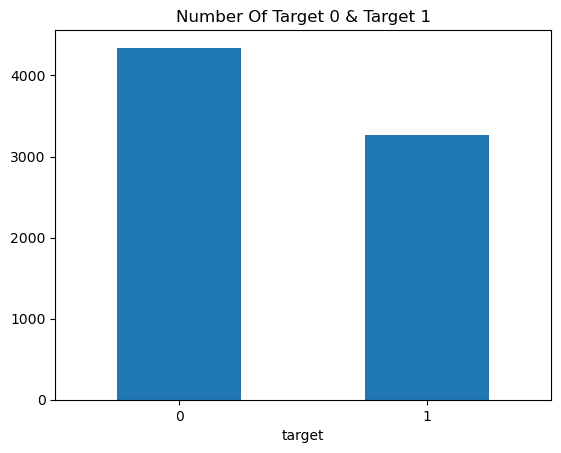

In [7]:
df_train['target'].value_counts().plot(kind = 'bar', title = 'Number Of Target 0 & Target 1', rot = 0);

In [12]:
data.index

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

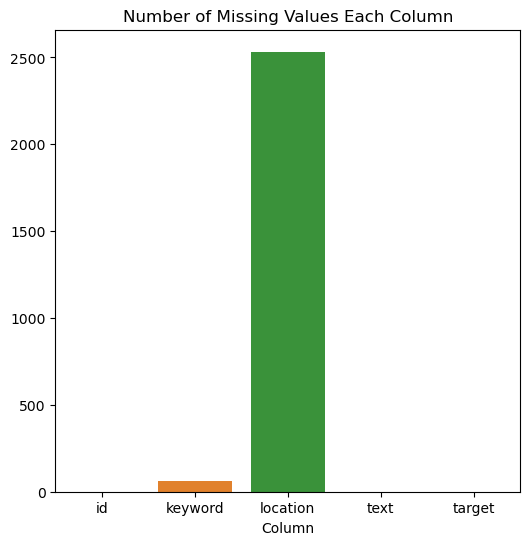

In [19]:
# Missing values
fig, ax = plt.subplots(figsize=(6, 6))
data = np.sum(df_train.isna(), axis=0)
sns.barplot(x=data.index, y=data.values, hue=data.index, ax=ax)
ax.set_title('Number of Missing Values In Each Column (Training)')
ax.set_xlabel('Column');

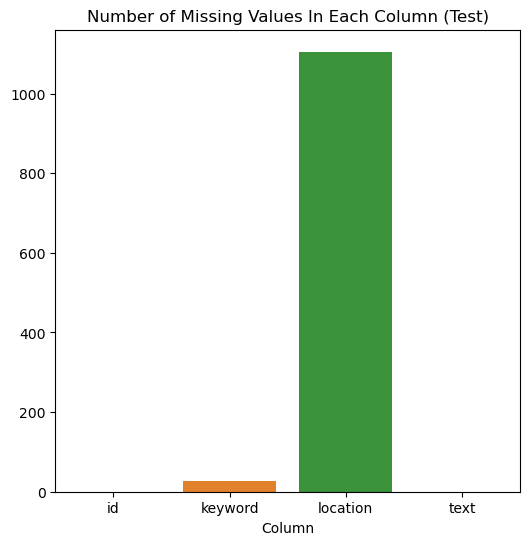

In [20]:
# Missing values
fig, ax = plt.subplots(figsize=(6, 6))
data = np.sum(df_test.isna(), axis=0)
sns.barplot(x=data.index, y=data.values, hue=data.index, ax=ax)
ax.set_title('Number of Missing Values In Each Column (Test)')
ax.set_xlabel('Column');